# Map query data

In [1]:
import os
import sys
sys.path.insert(0, "../")

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown

In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

### set relevant anndata.obs labels and training hyperparameters


In [4]:
condition_key = 'study'
cell_type_key = 'cell_type'
target_conditions = ['Pancreas CelSeq2', 'Pancreas SS2']


epoch = 100

early_stopping_kwargs = {
    "early_stopping_metric": "val_loss",
    "patience": 20,
    "threshold": 0,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

### Download Dataset and split into reference dataset and query dataset

In [5]:
#url = 'https://drive.google.com/uc?id=1ehxgfHTsMZXy6YzlFKGJOsBKQ5rrvMnd'
#output = 'pancreas.h5ad'
#gdown.download(url, output, quiet=False)

**Imortant note : scGen requires normalized and log-transformed data in `adata.X`**

In [6]:
adata = sc.read('pancreas.h5ad')

Here we use the CelSeq2 and SS2 studies as query data and the other 3 studies as reference atlas. We strongly suggest to use earlystopping to avoid over-fitting.

In [7]:
adata = remove_sparsity(adata) # remove sparsity 
source_adata = adata[~adata.obs[condition_key].isin(target_conditions)].copy()
target_adata = adata[adata.obs[condition_key].isin(target_conditions)].copy()

### Create scGen model and train it on reference dataset

Create the scgen model instance

In [8]:
network = sca.models.scgen(adata = source_adata, 
                           hidden_layer_sizes=[256,128])


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out: 1000 256
	Hidden Layer 1 in/out: 256 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out 10 128
	Hidden Layer 1 in/out: 128 256
	Output Layer in/out:  256 1000 



In [9]:
network.train(n_epochs=epoch, early_stopping_kwargs = early_stopping_kwargs)

 |███████████████-----| 77.0%  - epoch_loss: 1.9422808705 - val_loss: 1.9294649182
ADJUSTED LR
 |████████████████████| 100.0%  - epoch_loss: 1.9185013381 - val_loss: 1.9160817645
Saving best state of network...
Best State was in Epoch 94


### uncorrected reference data latent representation

In [10]:
reference_latent = sc.AnnData(network.to_latent())
reference_latent.obs["cell_type"] = source_adata.obs[cell_type_key].tolist()
reference_latent.obs["batch"] = source_adata.obs[condition_key].tolist()

In [11]:
sc.pp.neighbors(reference_latent)
sc.tl.umap(reference_latent)

... storing 'cell_type' as categorical
... storing 'batch' as categorical


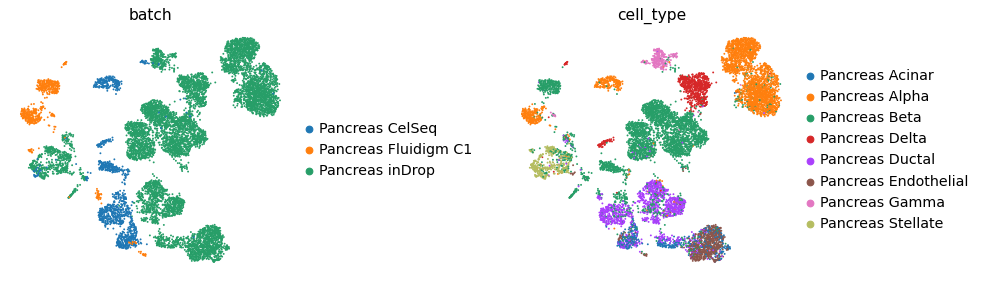

In [12]:
sc.pl.umap(reference_latent,
           color=['batch', 'cell_type'],
           frameon=False,save="ref.pdf", wspace=0.6)

### correct batches in reference data

This function return corrected gene expression in  `adata.X`, you can set `return_latent=True` and the it also return low-dimensional corrected latent space in `adata.obsm`

In [13]:
corrected_reference_adata = network.batch_removal(source_adata, batch_key="study", cell_label_key="cell_type",return_latent=True)

         Falling back to preprocessing with `sc.pp.pca` and default params.
... storing 'cell_type' as categorical


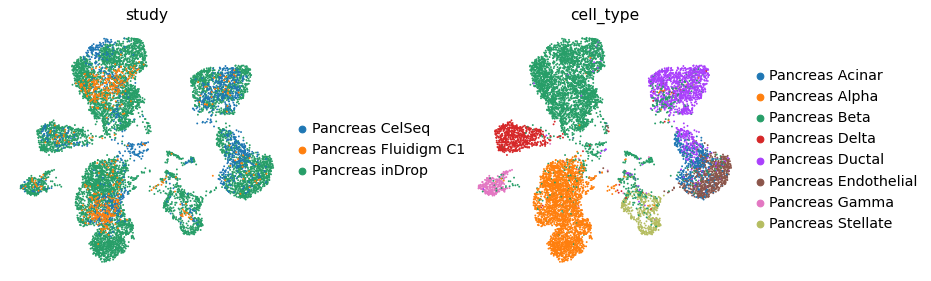

In [14]:
sc.pp.neighbors(corrected_reference_adata)
sc.tl.umap(corrected_reference_adata)
sc.pl.umap(corrected_reference_adata, color=["study", "cell_type"], wspace=.5, frameon=False)

### corrected reference data in latent representation

... storing 'cell_type' as categorical
... storing 'batch' as categorical


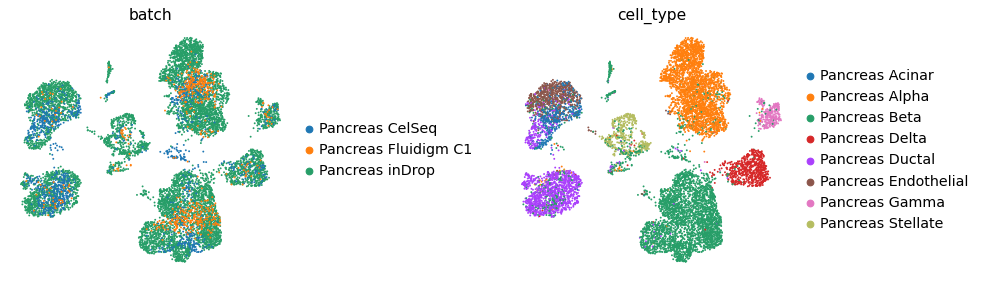

In [15]:
corrected_reference_latent = sc.AnnData(corrected_reference_adata.obsm["corrected"])
corrected_reference_latent.obs["cell_type"] = source_adata.obs[cell_type_key].tolist()
corrected_reference_latent.obs["batch"] = source_adata.obs[condition_key].tolist()
sc.pp.neighbors(corrected_reference_latent)
sc.tl.umap(corrected_reference_latent)
sc.pl.umap(corrected_reference_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

After pretraining the model can be saved for later use

In [16]:
ref_path = 'ref_model/'
network.save(ref_path, overwrite=True)

### Project query on top of the reference

query data needs to be preprocessed same way as reference data with same genes

This function need pretrained reference model, corrected gene expression from reference data and  incorrected query data 

In [17]:
integrated_query = sca.models.scgen.map_query_data(reference_model = ref_path,
                                                   corrected_reference = corrected_reference_adata,
                                                   query = target_adata, 
                                                   return_latent=True)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out: 1000 256
	Hidden Layer 1 in/out: 256 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out 10 128
	Hidden Layer 1 in/out: 128 256
	Output Layer in/out:  256 1000 



### Plot latent space of integrated_query and reference

In [18]:
adata_full = source_adata.concatenate(target_adata)
integrated_query_latent = sc.AnnData(integrated_query.obsm["corrected"])
integrated_query_latent.obs['cell_type'] = adata_full.obs[cell_type_key].tolist()
integrated_query_latent.obs['batch'] = adata_full.obs[condition_key].tolist()

In [19]:
adata_full

AnnData object with n_obs × n_vars = 15681 × 1000
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [20]:
sc.pp.neighbors(integrated_query_latent)
sc.tl.umap(integrated_query_latent)

... storing 'cell_type' as categorical
... storing 'batch' as categorical


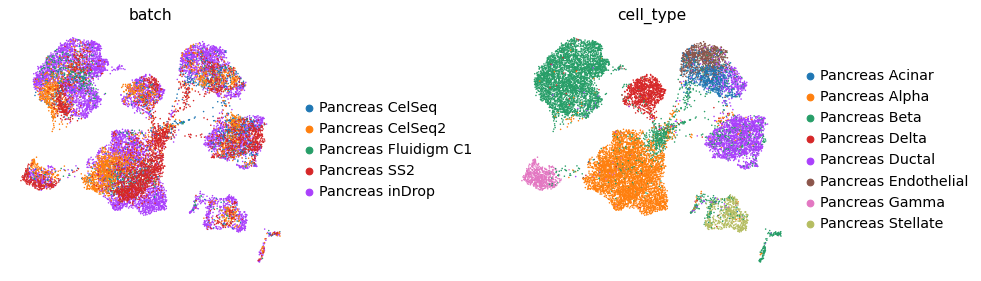

In [21]:
sc.pl.umap(
    integrated_query_latent,
    color=["batch", "cell_type"],
    frameon=False,
    wspace=0.6)